# file server age report

This jupyter notebook will take CSV data showing details about files on a network share, and generate graphs based on file size and age.


# 1 - import required libraries

In [1]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt



# 2 - define CSV source data


In [2]:
#CSV_source_file = 'https://raw.githubusercontent.com/nickjeffrey/GetFileDetails/main/filenames.csv'
CSV_source_file = 'c:/temp/filenames.csv'


In [3]:
# determine default system character set
import sys
print(sys.stdout.encoding)

UTF-8


In [4]:
# count the number of lines in the CSV file

def count_lines(file_path):
    try:
        with open(file_path, 'r',encoding='utf-8') as file:
            line_count = sum(1 for line in file)
        return line_count
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return 0
    except UnicodeDecodeError:
        # UnicodeDecodeError: 'utf-8' codec can't decode byte 0xff in position 0: invalid start byte
        print(f"Unable to decode the file with 'utf-8' encoding: {file_path}")
        print(f"The source CSV file may have a weird character set encoding")
        print(f"Try to fix with these commands from the Windows command prompt")
        print(f"type sourcefilename.csv | findstr , > sourcefilename.csv.tmp")
        print(f"copy sourcefilename.csv.tmp sourcefilename.csv")

# Example usage:
file_path = CSV_source_file
num_lines = count_lines(file_path)
print(f"Number of lines in the file: {num_lines}")

Number of lines in the file: 1415228


In [5]:
# extract all the lines from the source file that contain at least one comma, save to new temporary file
# this is how we eliminate any bogus lines in the source file (ie blank lines, headers, etc)




def find_lines_with_comma(input_file_path, output_file_path):
    try:
        with open(input_file_path, 'r', encoding='utf-8') as input_file:
            lines = input_file.readlines()

        matching_lines = [line.strip() for line in lines if ',' in line]

        with open(output_file_path, 'w', encoding='utf-8') as output_file:
            for line in matching_lines:
                output_file.write(line + '\n')

        print(f"Matching lines have been written to '{output_file_path}'.")

    except FileNotFoundError:
        print(f"File not found: {input_file_path}")
    except UnicodeDecodeError:
        print(f"Unable to decode the file with 'utf-8' encoding: {input_file_path}")
        print(f"The source CSV file may have a weird character set encoding")
        print(f"Try to fix with these commands from the Windows command prompt")
        print(f"type sourcefilename.csv | findstr , > sourcefilename.csv.tmp")
        print(f"copy sourcefilename.csv.tmp sourcefilename.csv")


# Example usage:
input_file_path = CSV_source_file
output_file_path = input_file_path   #start with name of source file
output_file_path += ".tmp"           #append .tmp to filename
find_lines_with_comma(input_file_path, output_file_path)

# Now make the cleaned up file the source file that all subsequent analysis will be performed on
CSV_source_file = output_file_path

Matching lines have been written to 'c:/temp/filenames.csv.tmp'.


In [6]:
# BUG ALERT: some weird filenames that contain oddball characters like 
#    embedded quotation marks or multiple commas in the filenames may 
#    not be correctly detected by the pd.read_csv directive. 
#    Figure out which files were not matched, and come up with an "exceptions list" for further investigation

In [7]:
# figure out the character set encoding of the source file


#import chardet
#from chardet.universaldetector import UniversalDetector

#detector = UniversalDetector()
#for line in open(CSV_temp_file,'rb'):
#    detector.feed(line)
#    if detector.done: break
#detector.close()
#print(detector.result)

# 2 - Load dataset into a Pandas DataFrame

In [8]:
#df = pd.read_csv('c:/temp/filenames.csv')  
#df = pd.read_csv('https://raw.githubusercontent.com/nickjeffrey/GetFileDetails/main/filenames.csv')
# df = pd.read_csv(CSV_source_file, encoding='UTF-16')  
df = pd.read_csv(CSV_source_file, on_bad_lines='skip',skip_blank_lines=True)



In [9]:
# look at the top few rows of the data to confirm the labels are correct
df.head()

,Filename,Bytes,MegaBytes,GigaBytes,CreationTimeEpoch,DaysSinceCreation,AccessTimeEpoch,DaysSinceAccess,LastWriteTimeEpoch,DaysSinceModification,MD5sum
0,s:\2-METRICS MANAGEMENT\0_Archive\Chapter.pdf,90864,0,0,1412586006,3206,1539075777,1742,1412586006,3206,0
1,s:\2-METRICS MANAGEMENT\0_Archive\CompletionsS...,9838846,9,0,1358864878,3828,1553786996,1572,1358864874,3828,0
2,s:\2-METRICS MANAGEMENT\0_Archive\f.txt,1127237,1,0,1340717505,4038,1539075777,1742,1340717505,4038,0
3,s:\2-METRICS MANAGEMENT\0_Archive\sql_summary.txt,9746,0,0,1348068859,3953,1539075777,1742,1348068873,3953,0
4,s:\2-METRICS MANAGEMENT\0_Archive\0_FINAL_SUBV...,343,0,0,1524132113,1915,1536049655,1777,1524132285,1915,0


In [10]:
# look at the bottom few rows of the data 
df.tail()

,Filename,Bytes,MegaBytes,GigaBytes,CreationTimeEpoch,DaysSinceCreation,AccessTimeEpoch,DaysSinceAccess,LastWriteTimeEpoch,DaysSinceModification,MD5sum
1415222,s:\Warehouse-OL\x OLD\x Reports for PrintShop\...,70436,0,0,1367936752,3723,1367938783,3723,1367936752,3723,0
1415223,s:\Warehouse-OL\x OLD\x Reports for PrintShop\...,619865,1,0,1367936620,3723,1367936908,3723,1367936621,3723,0
1415224,s:\Warehouse-OL\x OLD\x Reports for PrintShop\...,274268,0,0,1367936600,3723,1443095099,2853,1367936600,3723,0
1415225,s:\Warehouse-OL\x OLD\x Reports for PrintShop\...,530038,1,0,1367937002,3723,1397656086,3379,1367937002,3723,0
1415226,s:\Warehouse-OL\x OLD\x Reports for PrintShop\...,149341,0,0,1367936987,3723,1407336700,3267,1367936987,3723,0


In [11]:
# show number of rows in dataset
print ("Rows in dataset:", len(df))

Rows in dataset: 1415227


In [12]:
#view dimensions of dataset (rows and columns)
print ("Rows,columns in dataset:", df.shape)

Rows,columns in dataset: (1415227, 11)


In [13]:
# check to see if there are any missing values from the dataset

# all of the results should be zero, which would indicate there are not any null values in the dataset
# if there are any results greater than zero, it would indicate that some pieces of data are missing and should be cleaned up.
df.isnull().sum()

Filename                 0
Bytes                    0
MegaBytes                0
GigaBytes                0
CreationTimeEpoch        0
DaysSinceCreation        0
AccessTimeEpoch          0
DaysSinceAccess          0
LastWriteTimeEpoch       0
DaysSinceModification    0
MD5sum                   0
dtype: int64

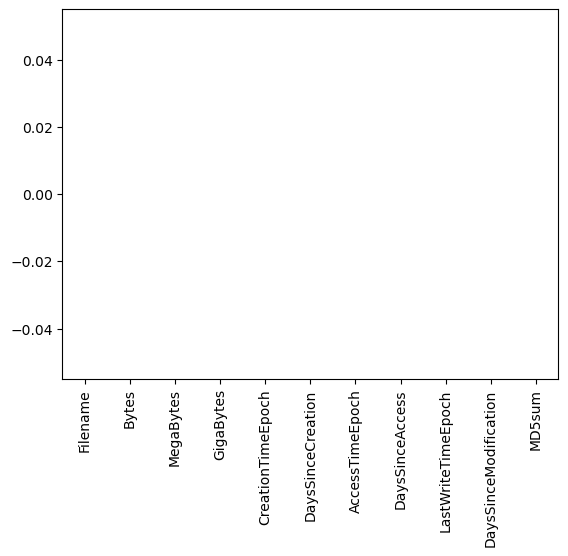

In [14]:
# visualize any missing values from the dataset in a histogram
# you want all the bars in the graph to be empty, which would indicate zero missing values

df.isnull().sum().plot.bar()
plt.show()

In [15]:
# another method to visalize missing values from dataset

print ("Checking for missing values in data set")

import matplotlib.pyplot as plt
def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh")
        plt.show()
    else:
        print('No NAs found')
plot_nas(df)


Checking for missing values in data set
No NAs found


In [16]:
#show the names of the columns (also called feature names)
df.columns

Index(['Filename', 'Bytes', 'MegaBytes', 'GigaBytes', 'CreationTimeEpoch',
       'DaysSinceCreation', 'AccessTimeEpoch', 'DaysSinceAccess',
       'LastWriteTimeEpoch', 'DaysSinceModification', 'MD5sum'],
      dtype='object')

In [17]:
#show summary info about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1415227 entries, 0 to 1415226
Data columns (total 11 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   Filename               1415227 non-null  object
 1   Bytes                  1415227 non-null  int64 
 2   MegaBytes              1415227 non-null  int64 
 3   GigaBytes              1415227 non-null  int64 
 4   CreationTimeEpoch      1415227 non-null  int64 
 5   DaysSinceCreation      1415227 non-null  int64 
 6   AccessTimeEpoch        1415227 non-null  int64 
 7   DaysSinceAccess        1415227 non-null  int64 
 8   LastWriteTimeEpoch     1415227 non-null  int64 
 9   DaysSinceModification  1415227 non-null  int64 
 10  MD5sum                 1415227 non-null  int64 
dtypes: int64(10), object(1)
memory usage: 118.8+ MB


In [18]:
# show data types 
df.dtypes

Filename                 object
Bytes                     int64
MegaBytes                 int64
GigaBytes                 int64
CreationTimeEpoch         int64
DaysSinceCreation         int64
AccessTimeEpoch           int64
DaysSinceAccess           int64
LastWriteTimeEpoch        int64
DaysSinceModification     int64
MD5sum                    int64
dtype: object

# rename features

In [19]:
# rename some features that have incorrect names

if 'DaysSinceCreation'     in df.columns: df.rename(columns={'DaysSinceCreation'     : 'CreationTimeDays'     }, inplace=True)
if 'DaysSinceAccess'       in df.columns: df.rename(columns={'DaysSinceAccess'       : 'AccessTimeDays'       }, inplace=True)
if 'DaysSinceModification' in df.columns: df.rename(columns={'DaysSinceModification' : 'ModificationTimeDays' }, inplace=True)
if 'LastWriteTimeEpoch'    in df.columns: df.rename(columns={'LastWriteTimeEpoch'    : 'ModificationTimeEpoch'}, inplace=True)

In [20]:
# look at the top few rows of the data to confirm the labels are correct
df.head()

,Filename,Bytes,MegaBytes,GigaBytes,CreationTimeEpoch,CreationTimeDays,AccessTimeEpoch,AccessTimeDays,ModificationTimeEpoch,ModificationTimeDays,MD5sum
0,s:\2-METRICS MANAGEMENT\0_Archive\Chapter.pdf,90864,0,0,1412586006,3206,1539075777,1742,1412586006,3206,0
1,s:\2-METRICS MANAGEMENT\0_Archive\CompletionsS...,9838846,9,0,1358864878,3828,1553786996,1572,1358864874,3828,0
2,s:\2-METRICS MANAGEMENT\0_Archive\f.txt,1127237,1,0,1340717505,4038,1539075777,1742,1340717505,4038,0
3,s:\2-METRICS MANAGEMENT\0_Archive\sql_summary.txt,9746,0,0,1348068859,3953,1539075777,1742,1348068873,3953,0
4,s:\2-METRICS MANAGEMENT\0_Archive\0_FINAL_SUBV...,343,0,0,1524132113,1915,1536049655,1777,1524132285,1915,0


# 3 - dimensionality reduction by removing features 

In this example, we are dropping some of the columns from the dataset that are not useful.
Please note that this is more of a "data science" exercise than a machine learning exercise, so it isn't that these features have no predictive value for a ML algorithm.


In [21]:
# drop any redundant columns from the dataset which does not have any predictive power. 

#In this example, we have features for bytes,MegaBytes, Gigabytes.
# We really only need the bytes column, so get rid of the other two.
if 'MegaBytes' in df.columns: df.drop('MegaBytes', axis=1, inplace=True)
if 'GigaBytes' in df.columns: df.drop('GigaBytes', axis=1, inplace=True)


# we really only care about the ModificationTimeDays, so drop the other timestamps
if 'CreationTimeEpoch'     in df.columns: df.drop('CreationTimeEpoch',     axis=1, inplace=True)
if 'CreationTimeDays'      in df.columns: df.drop('CreationTimeDays',      axis=1, inplace=True)
if 'AccessTimeEpoch'       in df.columns: df.drop('AccessTimeEpoch',       axis=1, inplace=True)
if 'AccessTimeDays'        in df.columns: df.drop('AccessTimeDays',        axis=1, inplace=True)
if 'ModificationTimeEpoch' in df.columns: df.drop('ModificationTimeEpoch', axis=1, inplace=True)

# There is a column for the MD5 checksum of each file, but at the moment, we only care about file age, so drop MD5sum
if 'MD5sum' in df.columns: df.drop('MD5sum', axis=1, inplace=True)



In [22]:
#Look at the dataset again, you should see several columns have been dropped
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1415227 entries, 0 to 1415226
Data columns (total 3 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   Filename              1415227 non-null  object
 1   Bytes                 1415227 non-null  int64 
 2   ModificationTimeDays  1415227 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 32.4+ MB


In [23]:
# At this point, we have 3 columns: Filename, Bytes, ModificationTimeDays
# look at the top few rows of the data to confirm the labels are correct
df.head()

,Filename,Bytes,ModificationTimeDays
0,s:\2-METRICS MANAGEMENT\0_Archive\Chapter.pdf,90864,3206
1,s:\2-METRICS MANAGEMENT\0_Archive\CompletionsS...,9838846,3828
2,s:\2-METRICS MANAGEMENT\0_Archive\f.txt,1127237,4038
3,s:\2-METRICS MANAGEMENT\0_Archive\sql_summary.txt,9746,3953
4,s:\2-METRICS MANAGEMENT\0_Archive\0_FINAL_SUBV...,343,1915


In [24]:
# drop rows to make the dataset a bit faster during testing
# Let's say we want to drop all rows between indices 10000 and 999999 inclusive. 
# We can do this with the drop() function and the range() function to generate the indices:
# df.drop(range(10000, 1000000), inplace=True)

In [25]:
#view dimensions of dataset (rows and columns)
print ("Rows,columns in dataset:", df.shape)

Rows,columns in dataset: (1415227, 3)


In [26]:
# At this point, we have 3 columns: Filename, Bytes, ModificationTimeDays
# look at the bottom few rows of the data to confirm the labels are correct
df.tail()

,Filename,Bytes,ModificationTimeDays
1415222,s:\Warehouse-OL\x OLD\x Reports for PrintShop\...,70436,3723
1415223,s:\Warehouse-OL\x OLD\x Reports for PrintShop\...,619865,3723
1415224,s:\Warehouse-OL\x OLD\x Reports for PrintShop\...,274268,3723
1415225,s:\Warehouse-OL\x OLD\x Reports for PrintShop\...,530038,3723
1415226,s:\Warehouse-OL\x OLD\x Reports for PrintShop\...,149341,3723


# 4 - Categorize filenames by age

In [27]:
# show a list of all the filenames with age 0 to  90 days old by extracting all rows with ModificationTimeDays <= 90
age0to90days = (df[(df['ModificationTimeDays'] >= 0) & (df['ModificationTimeDays'] < 90)])
print("Number of files with last modification date   0 to  90  days: ", (len(age0to90days)) )

# show a list of all the filenames with age 90 to 180 days
age90to180days = (df[(df['ModificationTimeDays'] >= 90) & (df['ModificationTimeDays'] < 180)])
print("Number of files with last modification date  90 to 180  days: ", (len(age90to180days)) )

# show a list of all the filenames with age 180 to 365 days
age180to365days = (df[(df['ModificationTimeDays'] >= 180) & (df['ModificationTimeDays'] < 365)])
print("Number of files with last modification date 180 to 365  days: ", (len(age180to365days)) )

# show a list of all the filenames with age 1 to 2 years days
age1to2years = (df[(df['ModificationTimeDays'] >= (365*1)) & (df['ModificationTimeDays'] < (365*2))])
print("Number of files with last modification date   1 to   2 years: ", (len(age1to2years)) )

# show a list of all the filenames with age 2 to 3 years days
age2to3years = (df[(df['ModificationTimeDays'] >= (365*2)) & (df['ModificationTimeDays'] < (365*3))])
print("Number of files with last modification date   2 to   3 years: ", (len(age2to3years)) )

# show a list of all the filenames with age 3 to 5 years days
age3to5years = (df[(df['ModificationTimeDays'] >= (365*3)) & (df['ModificationTimeDays'] < (365*5))])
print("Number of files with last modification date   3 to   5 years: ", (len(age3to5years)) )

# show a list of all the filenames with age 5 to 99 years days
age5to99years = (df[(df['ModificationTimeDays'] >= (365*5)) & (df['ModificationTimeDays'] < (365*99))])
print("Number of files with last modification date   5 to  99 years: ", (len(age5to99years)) )



Number of files with last modification date   0 to  90  days:  18219
Number of files with last modification date  90 to 180  days:  20342
Number of files with last modification date 180 to 365  days:  35372
Number of files with last modification date   1 to   2 years:  73283
Number of files with last modification date   2 to   3 years:  74754
Number of files with last modification date   3 to   5 years:  139723
Number of files with last modification date   5 to  99 years:  1053532


In [28]:
# create a bar graph with these vertical columns:
# age0to90days
# age90to180days
# age180to365days
# age1to2years
# age2to3years
# age3to5years
# age5to99years


## Create a sample dataframe with a text index
#plotdata = pd.DataFrame({"Filename Ages": [len(age0to90days), len(age90to180days), len(age180to365days), len(age1to2years), len(age2to3years), len(age3to5years), len(age5to99years)]}, index=["0to90days", "90to180days", "180to365days", "1to2years", "2to3years", "3to5years", "5to99years"])
## Plot a bar chart
##plt.title("Filename counts by age")
##plt.xlabel("File age")
##plt.ylabel("Number of files")
#plotdata.plot(kind="bar",title="Filename counts by age",xlabel="Last Modification Date",ylabel="Number of files")

# To do: 
# see if you can show the vertical axis in "thousands of files" (ie adjust the scale)


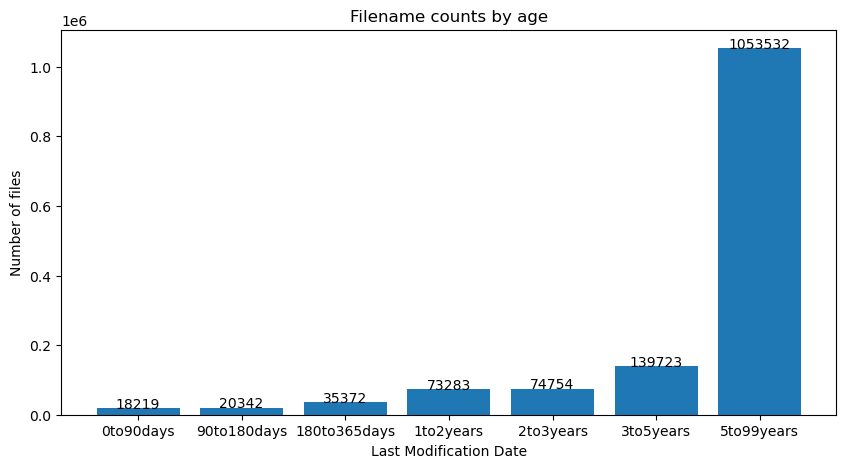

In [29]:
# create a better bar chart than the previous step by including value labels for each column

# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')
 
if __name__ == '__main__':
   
    # creating data on which bar chart will be plot
    x = "0to90days", "90to180days", "180to365days", "1to2years", "2to3years", "3to5years", "5to99years"
    y = [len(age0to90days), len(age90to180days), len(age180to365days), len(age1to2years), len(age2to3years), len(age3to5years), len(age5to99years)]
     
    # setting figure size by using figure() function
    plt.figure(figsize = (10, 5))
     
    # making the bar chart on the data
    plt.bar(x, y)
     
    # calling the function to add value labels
    addlabels(x, y)
     
    # giving title to the plot
    plt.title("Filename counts by age")
     
    # giving X and Y labels
    plt.xlabel("Last Modification Date")
    plt.ylabel("Number of files")
     
    # visualizing the plot
    plt.show()

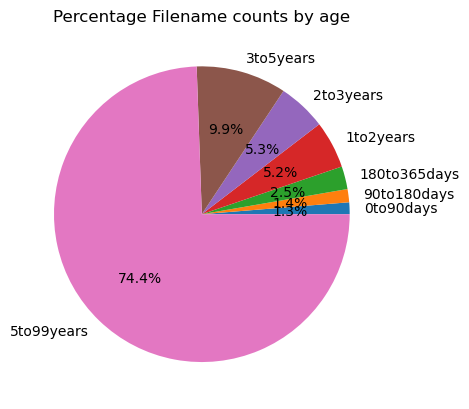

In [30]:
# create pie chart using the same data as the previous bar chart

labels = "0to90days", "90to180days", "180to365days", "1to2years", "2to3years", "3to5years", "5to99years"
sizes  = [len(age0to90days), len(age90to180days), len(age180to365days), len(age1to2years), len(age2to3years), len(age3to5years), len(age5to99years)]

plt.title("Percentage Filename counts by age")
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
#plt.legend(loc='right')
plt.show()


# 5 - calculate total bytes for each category of files
(this section is time consuming if you have a lot of rows in the dataset)

In [ ]:
# figure out the total number of bytes for each file category

# initialize variables
bytes0to90days    = 0
bytes90to180days  = 0
bytes180to365days = 0
bytes1to2years    = 0
bytes2to3years    = 0
bytes3to5years    = 0
bytes5to99years   = 0

print("Starting processing of", len(df), "files")
if len(df) > 1000000: print("Detected large input file, please be patient during processing...")
# loop through the contents of the dataframe to find the total number of bytes for each file age category
for i in range(0,len(df)):
    if (i % 100000 == 0):  print("Processed", i, "of", len(df), "files ", df.Filename[i], df.Bytes[i], df.ModificationTimeDays[i]) # print debug output every 100000 lines
    if (i+1 == (len(df))): print("Processed", i, "of", len(df), "files ", df.Filename[i], df.Bytes[i], df.ModificationTimeDays[i]) # print debug output for the last line so we know when the loop is finished
    if (df.ModificationTimeDays[i] >=0       and df.ModificationTimeDays[i] <  90):      bytes0to90days    += df.Bytes[i]
    if (df.ModificationTimeDays[i] >=90      and df.ModificationTimeDays[i] < 180):      bytes90to180days  += df.Bytes[i]
    if (df.ModificationTimeDays[i] >=180     and df.ModificationTimeDays[i] < 365):      bytes180to365days += df.Bytes[i]
    if (df.ModificationTimeDays[i] >=(365*1) and df.ModificationTimeDays[i] < (365*2)):  bytes1to2years    += df.Bytes[i]
    if (df.ModificationTimeDays[i] >=(365*2) and df.ModificationTimeDays[i] < (365*3)):  bytes2to3years    += df.Bytes[i]
    if (df.ModificationTimeDays[i] >=(365*3) and df.ModificationTimeDays[i] < (365*5)):  bytes3to5years    += df.Bytes[i]
    if (df.ModificationTimeDays[i] >=(365*5) and df.ModificationTimeDays[i] < (365*99)): bytes5to99years   += df.Bytes[i]


   


Starting processing of 1415227 files
Detected large input file, please be patient during processing...
Processed 0 of 1415227 files  s:\2-METRICS MANAGEMENT\0_Archive\Chapter.pdf 90864 3206
Processed 100000 of 1415227 files  s:\CurriculumServicesEditing\1 To Be Edited\A Assigned Archive\FY 2016-17\VISA 1111 - Chris to edit\VISA 1111 AF_Web_AC_AF-0416.docx 1499499 2632
Processed 200000 of 1415227 files  s:\Final Exams and Keys\Exams Version outdated\HRMN\HRMN 4891\HRMN4891_B_ak_30MAY16.docx 37278 2596
Processed 300000 of 1415227 files  s:\IDG-WorkFiles\Marlene B\Archive\Courses\MBA\Transferred to O\FINAL BUSN 5031 (MB)\BUSN 5031 Modules_Aug9_MB\BUSN 5031 Modules.doc 1431552 3633
Processed 400000 of 1415227 files  s:\IDRG-production\COURSES\COMPLETED\BBUS\BBUS3671_(ADMN367)\BBUS3671_(ADMN367)_MAY2006\ADMN367_Mod2_ts_noAsst.doc 323584 6293
Processed 500000 of 1415227 files  s:\IDRG-production\SOFTWARE\XML_SCRIPTING\COURSES_OUTPUT\anth2921-test\u03\u03_t03.html 3462 1232
Processed 600000 o

In [ ]:
print("Bytes with last modification date   0 to  90  days: ", bytes0to90days    )        
print("Bytes with last modification date  90 to 180  days: ", bytes90to180days  )        
print("Bytes with last modification date 180 to 365  days: ", bytes180to365days )        
print("Bytes with last modification date   1 to   2 years: ", bytes1to2years    )        
print("Bytes with last modification date   2 to   3 years: ", bytes2to3years    )        
print("Bytes with last modification date   3 to   5 years: ", bytes3to5years    )        
print("Bytes with last modification date   5 to  99 years: ", bytes5to99years   )        


In [ ]:
# convert bytes to more human-readable kilobytes for graphing
# use int() to convert the floating point value to the nearest integer (nearest GB is close enough)
Kbytes0to90days    = int(bytes0to90days/1024)
Kbytes90to180days  = int(bytes90to180days/1024)
Kbytes180to365days = int(bytes180to365days/1024)
Kbytes1to2years    = int(bytes1to2years/1024)
Kbytes2to3years    = int(bytes2to3years/1024)
Kbytes3to5years    = int(bytes3to5years/1024)
Kbytes5to99years   = int(bytes5to99years/1024)

print("KiloBytes with last modification date   0 to  90  days: ", Kbytes0to90days    )        
print("KiloBytes with last modification date  90 to 180  days: ", Kbytes90to180days  )        
print("KiloBytes with last modification date 180 to 365  days: ", Kbytes180to365days )        
print("KiloBytes with last modification date   1 to   2 years: ", Kbytes1to2years    )        
print("KiloBytes with last modification date   2 to   3 years: ", Kbytes2to3years    )        
print("KiloBytes with last modification date   3 to   5 years: ", Kbytes3to5years    )        
print("KiloBytes with last modification date   5 to  99 years: ", Kbytes5to99years   ) 


In [ ]:
# convert bytes to more human-readable megabytes for graphing
# use int() to convert the floating point value to the nearest integer (nearest GB is close enough)
Mbytes0to90days    = int(bytes0to90days/1024/1024)
Mbytes90to180days  = int(bytes90to180days/1024/1024)
Mbytes180to365days = int(bytes180to365days/1024/1024)
Mbytes1to2years    = int(bytes1to2years/1024/1024)
Mbytes2to3years    = int(bytes2to3years/1024/1024)
Mbytes3to5years    = int(bytes3to5years/1024/1024)
Mbytes5to99years   = int(bytes5to99years/1024/1024)

print("MegaBytes with last modification date   0 to  90  days: ", Mbytes0to90days    )        
print("MegaBytes with last modification date  90 to 180  days: ", Mbytes90to180days  )        
print("MegaBytes with last modification date 180 to 365  days: ", Mbytes180to365days )        
print("MegaBytes with last modification date   1 to   2 years: ", Mbytes1to2years    )        
print("MegaBytes with last modification date   2 to   3 years: ", Mbytes2to3years    )        
print("MegaBytes with last modification date   3 to   5 years: ", Mbytes3to5years    )        
print("MegaBytes with last modification date   5 to  99 years: ", Mbytes5to99years   ) 


In [ ]:
# convert bytes to more human-readable gigabytes for graphing
# use int() to convert the floating point value to the nearest integer (nearest MB is close enough)
Gbytes0to90days    = int(bytes0to90days/1024/1024/1024)
Gbytes90to180days  = int(bytes90to180days/1024/1024/1024)
Gbytes180to365days = int(bytes180to365days/1024/1024/1024)
Gbytes1to2years    = int(bytes1to2years/1024/1024/1024)
Gbytes2to3years    = int(bytes2to3years/1024/1024/1024)
Gbytes3to5years    = int(bytes3to5years/1024/1024/1024)
Gbytes5to99years   = int(bytes5to99years/1024/1024/1024)

print("GigaBytes with last modification date   0 to  90  days: ", Gbytes0to90days    )        
print("GigaBytes with last modification date  90 to 180  days: ", Gbytes90to180days  )        
print("GigaBytes with last modification date 180 to 365  days: ", Gbytes180to365days )        
print("GigaBytes with last modification date   1 to   2 years: ", Gbytes1to2years    )        
print("GigaBytes with last modification date   2 to   3 years: ", Gbytes2to3years    )        
print("GigaBytes with last modification date   3 to   5 years: ", Gbytes3to5years    )        
print("GigaBytes with last modification date   5 to  99 years: ", Gbytes5to99years   )        

In [ ]:
# convert bytes to more human-readable terabytes for graphing
# use int() to convert the floating point value to the nearest integer (nearest TB is close enough)
Tbytes0to90days    = int(bytes0to90days/1024/1024/1024/1024)
Tbytes90to180days  = int(bytes90to180days/1024/1024/1024/1024)
Tbytes180to365days = int(bytes180to365days/1024/1024/1024/1024)
Tbytes1to2years    = int(bytes1to2years/1024/1024/1024/1024)
Tbytes2to3years    = int(bytes2to3years/1024/1024/1024/1024)
Tbytes3to5years    = int(bytes3to5years/1024/1024/1024/1024)
Tbytes5to99years   = int(bytes5to99years/1024/1024/1024/1024)

print("TeraBytes with last modification date   0 to  90  days: ", Tbytes0to90days    )        
print("TeraBytes with last modification date  90 to 180  days: ", Tbytes90to180days  )        
print("TeraBytes with last modification date 180 to 365  days: ", Tbytes180to365days )        
print("TeraBytes with last modification date   1 to   2 years: ", Tbytes1to2years    )        
print("TeraBytes with last modification date   2 to   3 years: ", Tbytes2to3years    )        
print("TeraBytes with last modification date   3 to   5 years: ", Tbytes3to5years    )        
print("TeraBytes with last modification date   5 to  99 years: ", Tbytes5to99years   )     

In [ ]:
# convert bytes to more human-readable petabytes for graphing
# use int() to convert the floating point value to the nearest integer (nearest PB is close enough)
Pbytes0to90days    = int(bytes0to90days/1024/1024/1024/1024/1024)
Pbytes90to180days  = int(bytes90to180days/1024/1024/1024/1024/1024)
Pbytes180to365days = int(bytes180to365days/1024/1024/1024/1024/1024)
Pbytes1to2years    = int(bytes1to2years/1024/1024/1024/1024/1024)
Pbytes2to3years    = int(bytes2to3years/1024/1024/1024/1024/1024)
Pbytes3to5years    = int(bytes3to5years/1024/1024/1024/1024/1024)
Pbytes5to99years   = int(bytes5to99years/1024/1024/1024/1024/1024)

print("PetaBytes with last modification date   0 to  90  days: ", Pbytes0to90days    )        
print("PetaBytes with last modification date  90 to 180  days: ", Pbytes90to180days  )        
print("PetaBytes with last modification date 180 to 365  days: ", Pbytes180to365days )        
print("PetaBytes with last modification date   1 to   2 years: ", Pbytes1to2years    )        
print("PetaBytes with last modification date   2 to   3 years: ", Pbytes2to3years    )        
print("PetaBytes with last modification date   3 to   5 years: ", Pbytes3to5years    )        
print("PetaBytes with last modification date   5 to  99 years: ", Pbytes5to99years   ) 

In [ ]:
# Based on the byte counts, figure out the preferred unit value (Bytes, MegaBytes, GigaBytes, TeraBytes) to use for graphing
if (bytes0to90days  >= 0):  y_axis_units = "Bytes"  #start with default value of bytes
if (Kbytes0to90days >= 10): y_axis_units = "KiloBytes"
if (Mbytes0to90days >= 10): y_axis_units = "MegaBytes"
if (Gbytes0to90days >= 10): y_axis_units = "GigaBytes"
if (Tbytes0to90days >= 10): y_axis_units = "TeraBytes"
if (Pbytes0to90days >= 10): y_axis_units = "PetaBytes"
print ("Based on file sizes, the vertical y-axis units will be shown in ", y_axis_units)

## manually edit y_axis_units if desired
##y_axis_units = "GigaBytes"

In [ ]:
# create a bar graph with these vertical columns:
# bytes0to90days
# bytes90to180days
# bytes180to365days
# bytes1to2years
# bytes2to3years
# bytes3to5years
# bytes5to99years






## Create a sample dataframe with a text index
#if (y_axis_units == "Bytes"):     plotdata = pd.DataFrame({"Bytes by Age":     [ bytes0to90days,  bytes90to180days,  bytes180to365days,  bytes1to2years,  bytes2to3years,  bytes3to5years,  bytes5to99years]}, index=["0to90days", "90to180days", "180to365days", "1to2years", "2to3years", "3to5years", "5to99years"])
#if (y_axis_units == "KiloBytes"): plotdata = pd.DataFrame({"KiloBytes by Age": [Kbytes0to90days, Kbytes90to180days, Kbytes180to365days, Kbytes1to2years, Kbytes2to3years, Kbytes3to5years, Kbytes5to99years]}, index=["0to90days", "90to180days", "180to365days", "1to2years", "2to3years", "3to5years", "5to99years"])
#if (y_axis_units == "MegaBytes"): plotdata = pd.DataFrame({"MegaBytes by Age": [Mbytes0to90days, Mbytes90to180days, Mbytes180to365days, Mbytes1to2years, Mbytes2to3years, Mbytes3to5years, Mbytes5to99years]}, index=["0to90days", "90to180days", "180to365days", "1to2years", "2to3years", "3to5years", "5to99years"])    
#if (y_axis_units == "GigaBytes"): plotdata = pd.DataFrame({"GigaBytes by Age": [Gbytes0to90days, Gbytes90to180days, Gbytes180to365days, Gbytes1to2years, Gbytes2to3years, Gbytes3to5years, Gbytes5to99years]}, index=["0to90days", "90to180days", "180to365days", "1to2years", "2to3years", "3to5years", "5to99years"])
#if (y_axis_units == "TeraBytes"): plotdata = pd.DataFrame({"TeraBytes by Age": [Tbytes0to90days, Tbytes90to180days, Tbytes180to365days, Tbytes1to2years, Tbytes2to3years, Tbytes3to5years, Tbytes5to99years]}, index=["0to90days", "90to180days", "180to365days", "1to2years", "2to3years", "3to5years", "5to99years"])        
#if (y_axis_units == "PetaBytes"): plotdata = pd.DataFrame({"PetaBytes by Age": [Pbytes0to90days, Pbytes90to180days, Pbytes180to365days, Pbytes1to2years, Pbytes2to3years, Pbytes3to5years, Pbytes5to99years]}, index=["0to90days", "90to180days", "180to365days", "1to2years", "2to3years", "3to5years", "5to99years"])        

## plot the data
#plotdata.plot(kind="bar",title="Byte counts by age",xlabel="Last Modification Date",ylabel=y_axis_units)



In [ ]:
# create a better bar chart than the previous step by including value labels for each column



# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')
 
if __name__ == '__main__':
   
    # creating data on which bar chart will be plot
    x = "0to90days", "90to180days", "180to365days", "1to2years", "2to3years", "3to5years", "5to99years"
    #
    # Based on how big the numbers are, figure out if the vertical y-axis should be in bytes, Mbytes, Gbytes, Tbytes, Pbytes
    if (y_axis_units == "Bytes"):     y = [ bytes0to90days,  bytes90to180days,  bytes180to365days,  bytes1to2years,  bytes2to3years,  bytes3to5years,  bytes5to99years]
    if (y_axis_units == "MegaBytes"): y = [Mbytes0to90days, Mbytes90to180days, Mbytes180to365days, Mbytes1to2years, Mbytes2to3years, Mbytes3to5years, Mbytes5to99years]
    if (y_axis_units == "GigaBytes"): y = [Gbytes0to90days, Gbytes90to180days, Gbytes180to365days, Gbytes1to2years, Gbytes2to3years, Gbytes3to5years, Gbytes5to99years]
    if (y_axis_units == "TeraBytes"): y = [Tbytes0to90days, Tbytes90to180days, Tbytes180to365days, Tbytes1to2years, Tbytes2to3years, Tbytes3to5years, Tbytes5to99years]
    if (y_axis_units == "PetaBytes"): y = [Pbytes0to90days, Pbytes90to180days, Pbytes180to365days, Pbytes1to2years, Pbytes2to3years, Pbytes3to5years, Pbytes5to99years]

     
    # setting figure size by using figure() function
    plt.figure(figsize = (10, 5))
     
    # making the bar chart on the data
    plt.bar(x, y)
     
    # calling the function to add value labels
    addlabels(x, y)
     
    # giving title to the plot
    plt.title("Total storage consumed by file age")
     
    # giving X and Y labels
    plt.xlabel("Last Modification Date")
    plt.ylabel("Number of bytes")
    if (y_axis_units == "Bytes"):     plt.ylabel("Bytes")
    if (y_axis_units == "KiloBytes"): plt.ylabel("Kilobytes")
    if (y_axis_units == "MegaBytes"): plt.ylabel("MegaBbytes")
    if (y_axis_units == "GigaBytes"): plt.ylabel("GigaBytes")
    if (y_axis_units == "TeraBytes"): plt.ylabel("TeraBytes")
    if (y_axis_units == "PetaBytes"): plt.ylabel("PetaBytes")

     
    # visualizing the plot
    plt.show()

In [ ]:
# create pie chart using the same data as the previous bar chart

labels = "0to90days", "90to180days", "180to365days", "1to2years", "2to3years", "3to5years", "5to99years"
sizes  = [bytes0to90days, bytes90to180days, bytes180to365days, bytes1to2years, bytes2to3years, bytes3to5years, bytes5to99years]

plt.title("Percentage Byte counts by age")
#plt.xlabel("Age")
#plt.ylabel("GigaBytes")
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
#plt.legend()
plt.show()

# 6 - Create reports in CSV format of each category of files


In [ ]:

# Generate reports in CSV format showing the list of filenames, bytes, ModificationTimeDays

## open file for writing
#CSV_temp_file = CSV_source_file   #start with name of source file
#CSV_temp_file += ".tmp"           #append .tmp to filename

CSV_output_file = CSV_source_file   #start with name of source file
CSV_output_file += "_0to90days.csv" #append date range to filename
df_output_file  = df[ (df['ModificationTimeDays'] >= 0)        & (df['ModificationTimeDays'] < 90)]  
print ("Creating CSV output file showing all filenames with ages at:", CSV_output_file)
df_output_file.to_csv(CSV_output_file)

CSV_output_file = CSV_source_file   #start with name of source file
CSV_output_file += "_90to180days.csv" #append date range to filename
df_output_file  = df[ (df['ModificationTimeDays'] >= 90)     & (df['ModificationTimeDays'] < 180)]  
print ("Creating CSV output file showing all filenames with ages at:", CSV_output_file)
df_output_file.to_csv(CSV_output_file)

CSV_output_file = CSV_source_file   #start with name of source file
CSV_output_file += "_180to365days.csv" #append date range to filename
df_output_file = df[ (df['ModificationTimeDays'] >= 180)   & (df['ModificationTimeDays'] < 365)]  
print ("Creating CSV output file showing all filenames with ages at:", CSV_output_file)
df_output_file.to_csv(CSV_output_file)

CSV_output_file = CSV_source_file   #start with name of source file
CSV_output_file += "_1to2years.csv" #append date range to filename
df_output_file = df[ (df['ModificationTimeDays'] >= (365*1))  & (df['ModificationTimeDays'] < (365*2))]  
print ("Creating CSV output file showing all filenames with ages at:", CSV_output_file)
df_output_file.to_csv(CSV_output_file)

CSV_output_file = CSV_source_file   #start with name of source file
CSV_output_file += "_2to3years.csv" #append date range to filename
df_output_file = df[ (df['ModificationTimeDays'] >= (365*2))  & (df['ModificationTimeDays'] < (365*3))]  
print ("Creating CSV output file showing all filenames with ages at:", CSV_output_file)
df_output_file.to_csv(CSV_output_file)

CSV_output_file = CSV_source_file   #start with name of source file
CSV_output_file += "_3to5years.csv" #append date range to filename
df_output_file = df[ (df['ModificationTimeDays'] >= (365*3))  & (df['ModificationTimeDays'] < (365*5))]  
print ("Creating CSV output file showing all filenames with ages at:", CSV_output_file)
df_output_file.to_csv(CSV_output_file)

CSV_output_file = CSV_source_file   #start with name of source file
CSV_output_file += "_5to99years.csv" #append date range to filename
df_output_file= df[ (df['ModificationTimeDays'] >= (365*5)) & (df['ModificationTimeDays'] < (365*99))]  
print ("Creating CSV output file showing all filenames with ages at:", CSV_output_file)
df_output_file.to_csv(CSV_output_file)

print ("Finished creating CSV output files")

                                                               



In [ ]:
# Delete temporary file
import os
from pathlib import Path
if os.path.isfile(CSV_source_file):
    os.remove(CSV_source_file)
    print ("Deleting temporary file",CSV_source_file)
    

